In [2]:
import cv2#reading and resizing                 
import numpy as np#arrays         
import os#dealing with directories                  
from random import shuffle #to shuffle data
from tqdm import tqdm#loop progress bar  
from sklearn.metrics import roc_auc_score    
import matplotlib.pyplot as plt # for visualizations
import tensorflow as tf # For tensor operations
import pandas as pd # for manipulating data
import zipfile
import os, sys

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import Dense,Dropout,Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam,RMSprop,Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.applications.vgg16 import preprocess_input,decode_predictions
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_unmasked1=np.load("/content/drive/MyDrive/dataset_1 (1)/without mask m.npy")
data_unmasked1.shape

(8815, 64, 64, 3)

In [6]:
data_unmasked=np.concatenate((data_unmasked1, data_unmasked1), axis=0)
data_unmasked.shape

(17630, 64, 64, 3)

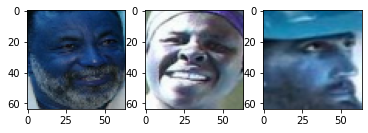

In [7]:
# Visualize data
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(data_unmasked[i])

In [8]:
data_masked=np.load("/content/drive/MyDrive/dataset_1 (1)/with mask m.npy")
data_masked=data_masked[0:17630]
data_masked.shape

(17630, 64, 64, 3)

In [9]:
data=np.concatenate((data_unmasked, data_masked), axis=0)


In [10]:
data

array([[[[  0,  12,  14],
         [  1,  10,  10],
         [  6,  12,  10],
         ...,
         [ 92, 156, 190],
         [111, 175, 212],
         [107, 171, 206]],

        [[  1,  14,  16],
         [  3,  14,  14],
         [  6,  14,  14],
         ...,
         [ 76, 148, 177],
         [111, 172, 204],
         [113, 176, 206]],

        [[  0,  11,  13],
         [  0,   8,   9],
         [  0,  12,  16],
         ...,
         [ 82, 158, 187],
         [115, 177, 208],
         [116, 180, 208]],

        ...,

        [[186, 205, 213],
         [185, 203, 215],
         [182, 200, 217],
         ...,
         [173, 180, 183],
         [176, 184, 187],
         [179, 186, 189]],

        [[186, 204, 211],
         [185, 201, 212],
         [181, 199, 216],
         ...,
         [174, 181, 184],
         [177, 183, 186],
         [179, 186, 189]],

        [[188, 206, 217],
         [186, 203, 216],
         [182, 201, 216],
         ...,
         [177, 182, 183],
        

In [11]:
data_unmasked.shape

(17630, 64, 64, 3)

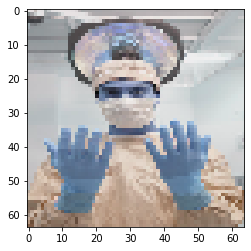

In [12]:
# Visualize data
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(data[17630])

In [13]:
un_masked_label= np.reshape(np.array((["un_masked" for _ in range(17630)])),(17630,1))
un_masked_label.shape

(17630, 1)

# New Section

In [14]:
masked_label = np.reshape(np.array((["masked" for _ in range(17630)])),(17630,1))
masked_label.shape

(17630, 1)

In [15]:
data.shape



(35260, 64, 64, 3)

In [16]:
label=np.concatenate((un_masked_label,masked_label), axis=0)
label.shape

(35260, 1)

In [17]:
label

array([['un_masked'],
       ['un_masked'],
       ['un_masked'],
       ...,
       ['masked'],
       ['masked'],
       ['masked']], dtype='<U9')

In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

enc.fit(label)

# 3. Transform
onehotlabels = enc.transform(label).toarray()
onehotlabels.shape

(35260, 2)

In [19]:
onehotlabels[1]

array([0., 1.])

In [20]:
onehotlabels[10000]

array([0., 1.])

In [21]:
x=data
y=onehotlabels
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=11)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5,random_state=65)

In [22]:
print("x-tarin: ",x_train.shape,' x_test: ',x_test.shape," x_val: ",x_test.shape)
print("y-tarin: ",y_train.shape,' y_test: ',y_test.shape," y_val: ",y_test.shape)

x-tarin:  (24682, 64, 64, 3)  x_test:  (5289, 64, 64, 3)  x_val:  (5289, 64, 64, 3)
y-tarin:  (24682, 2)  y_test:  (5289, 2)  y_val:  (5289, 2)


In [23]:
# as first layer in a Sequential model  
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((64, 64, 3)))

In [24]:
model = tf.keras.models.Sequential()

# Input layer
# Can be omitted, you can specify the input_shape in other layers
model.add(tf.keras.layers.InputLayer(input_shape=(64,64,3)))

# Here we add a 2D Convolution layer
# Check https://keras.io/api/layers/convolution_layers/convolution2d/ for more info
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

#Add Output Layer

model.add(tf.keras.layers.Dense(2, activation=tf.nn.sigmoid))

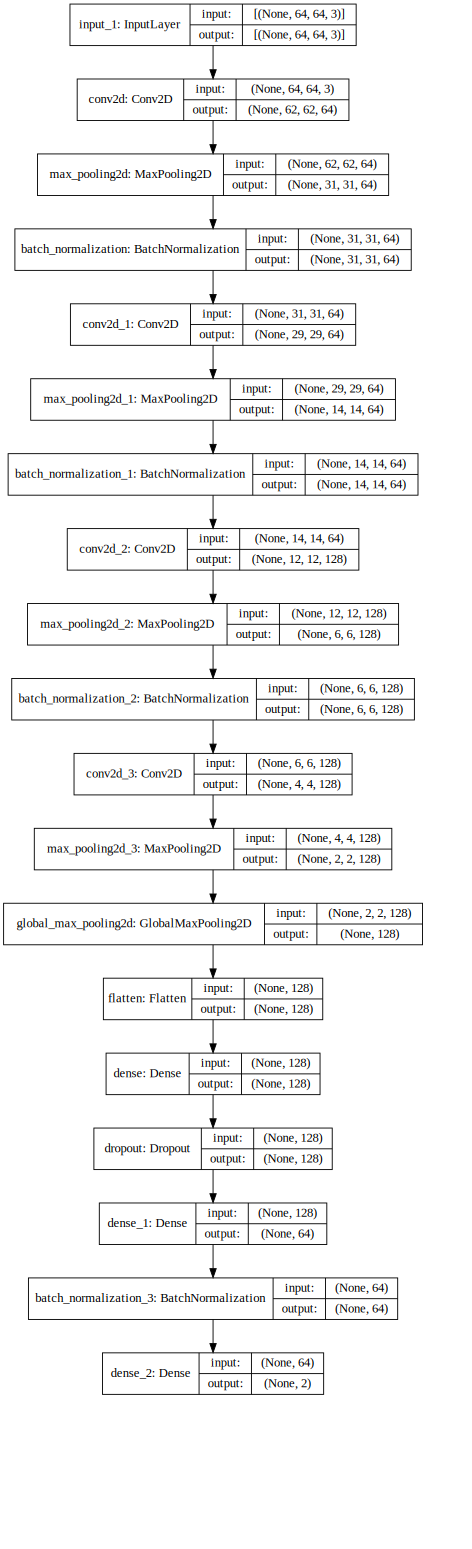

In [25]:
#Displaying SVG
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True,show_layer_names=True,rankdir='TB').create(prog='dot',format='svg'))
#resize the(svg)
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [26]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=["accuracy"])

In [27]:

# after trying i found that batch_sixe=64 and epochs=100 giving the best accuracy
cnn=model.fit(x_train,y_train,batch_size=128,epochs=25,verbose=0,validation_data=(x_val,y_val),shuffle=True)

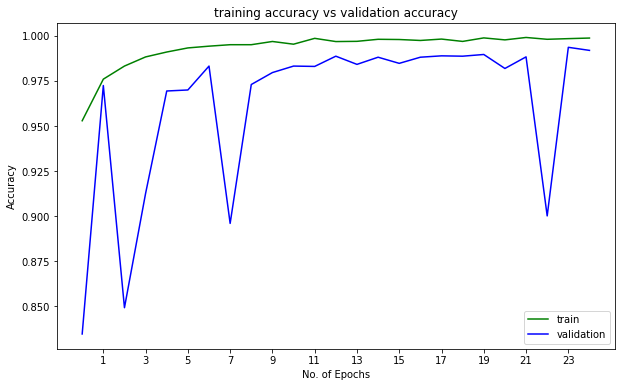

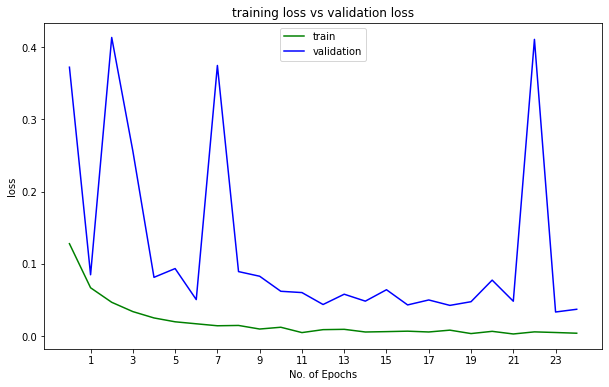

In [28]:
plt.figure(figsize=(10,6))
plt.plot(cnn.history['accuracy'],'g')
plt.plot(cnn.history['val_accuracy'],'b')
plt.xticks(np.arange(1,25,2))
plt.title('training accuracy vs validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cnn.history['loss'],'g')
plt.plot(cnn.history['val_loss'],'b')
plt.xticks(np.arange(1,25,2))
plt.title('training loss vs validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()


In [29]:
pred=model.predict(x_test,verbose=1)


166/166 [==============================] - 1s 3ms/step


In [30]:

#computing test acc
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_acc)

166/166 - 0s - loss: 0.0326 - accuracy: 0.9936
0.9935715794563293


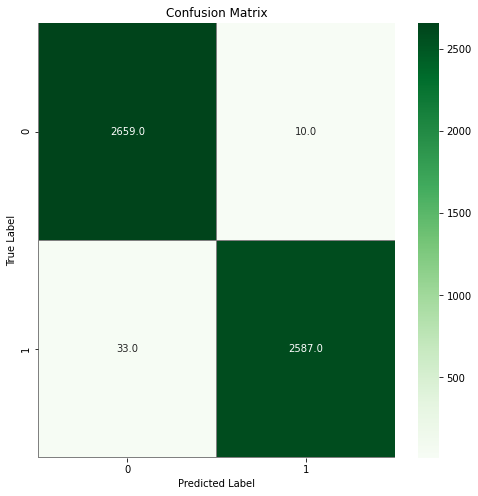

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

AxesImage(54,36;334.8x217.44)
for x_test {6} y_pred =  [['un_masked']]   /  y_test =  [['un_masked']]


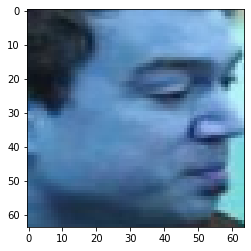

AxesImage(54,36;334.8x217.44)
for x_test {50} y_pred =  [['un_masked']]   /  y_test =  [['un_masked']]


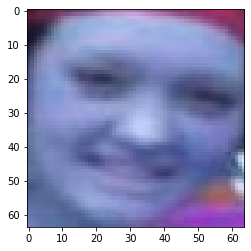

AxesImage(54,36;334.8x217.44)
for x_test {856} y_pred =  [['masked']]   /  y_test =  [['un_masked']]


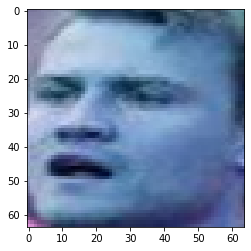

AxesImage(54,36;334.8x217.44)
for x_test {219} y_pred =  [['masked']]   /  y_test =  [['masked']]


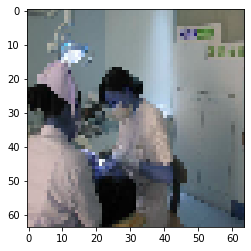

AxesImage(54,36;334.8x217.44)
for x_test {938} y_pred =  [['un_masked']]   /  y_test =  [['un_masked']]


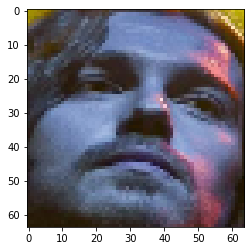

AxesImage(54,36;334.8x217.44)
for x_test {820} y_pred =  [['un_masked']]   /  y_test =  [['masked']]


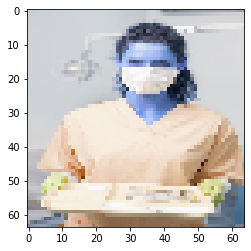

AxesImage(54,36;334.8x217.44)
for x_test {174} y_pred =  [['masked']]   /  y_test =  [['masked']]


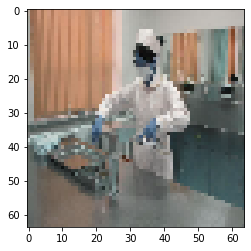

AxesImage(54,36;334.8x217.44)
for x_test {539} y_pred =  [['masked']]   /  y_test =  [['masked']]


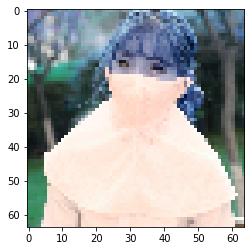

In [37]:
for i in [6,50,856,219,938,820,174,539]:
  plt.show()
  print(plt.imshow(x_test[i]))
  print("for x_test",{i}, "y_pred = ",enc.inverse_transform(y_pred[i].reshape(1,-1)),"  /  y_test = ",enc.inverse_transform(y_test[i].reshape(1,-1)))

In [38]:
model.save("maskdetector.model", save_format="h5")


In [63]:
pr=(cv2.resize(cv2.imread("/content/download (1).jpg"), (128,128 ))) 

In [65]:
pr2=(cv2.resize(cv2.imread("/content/download.jpg"), (128,128 ))) 

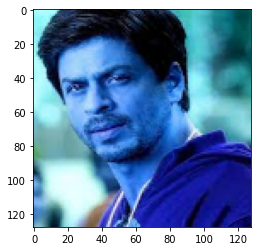

In [55]:
plt.imshow(pr)

In [64]:
pr = np.expand_dims(pr, axis=0)
enc.inverse_transform(model.predict(pr).reshape(1,-1))

array([['un_masked']], dtype='<U9')

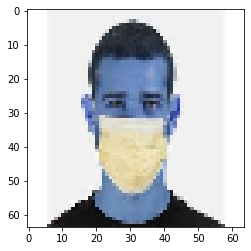

In [60]:
plt.imshow(pr2)

In [67]:
pr2 = np.expand_dims(pr2, axis=0)
enc.inverse_transform(model.predict(pr2).reshape(1,-1))

array([['masked']], dtype='<U9')